# Data Mining Project

## Or Levi - 305776221
## Shani Shochat - 308353796
## Adi Dagan - 203203658

## Import libraries

In [292]:
import numpy as np
import scipy
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA
from sklearn.preprocessing import StandardScaler # Normalize - Standard Scaler
from sklearn.preprocessing import MinMaxScaler # Normalize - MinMaxScaler
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn import neighbors #KNN
from sklearn.neural_network import MLPClassifier # Neural Network
from sklearn.ensemble import AdaBoostClassifier # Adaptive Boosting
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split, KFold       # K-Fold
from scipy import interp                        # ROC/AUC calculations
import itertools                                # Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc # Confusion Matrix, ROC, AUC
from IPython.display import display, HTML # Displaying results in an organized table
from collections import OrderedDict
import pylab 
import scipy.stats as stats

## Load external data

In [336]:
df = pd.read_csv('train.csv').iloc[:, 1:]
x, y = df.values[:,:-1], df.values[:, -1]
labels = df.columns.values[:-1]

df_test = pd.read_csv('test_without_target.csv').iloc[:, 1:]
x_test = df_test.values[:,:]

k_results = pd.read_excel('auc_results_output.xlsx', 'K options')
knn_results = pd.read_excel('auc_results_output.xlsx', 'KNN')
neural_network_results = pd.read_excel('auc_results_output.xlsx', 'Neural Network')
adaptive_boosting_results = pd.read_excel('auc_results_output.xlsx', 'Adaptive Boosting')

# Data Exploration

## Data Shape

In [337]:
print "the data has", x.shape[0], "observations", "and", x.shape[1], "features."

the data has 18750 observations and 50 features.


In [338]:
print labels

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44' '45' '46'
 '47' '48' '49']


## Scatter Plots

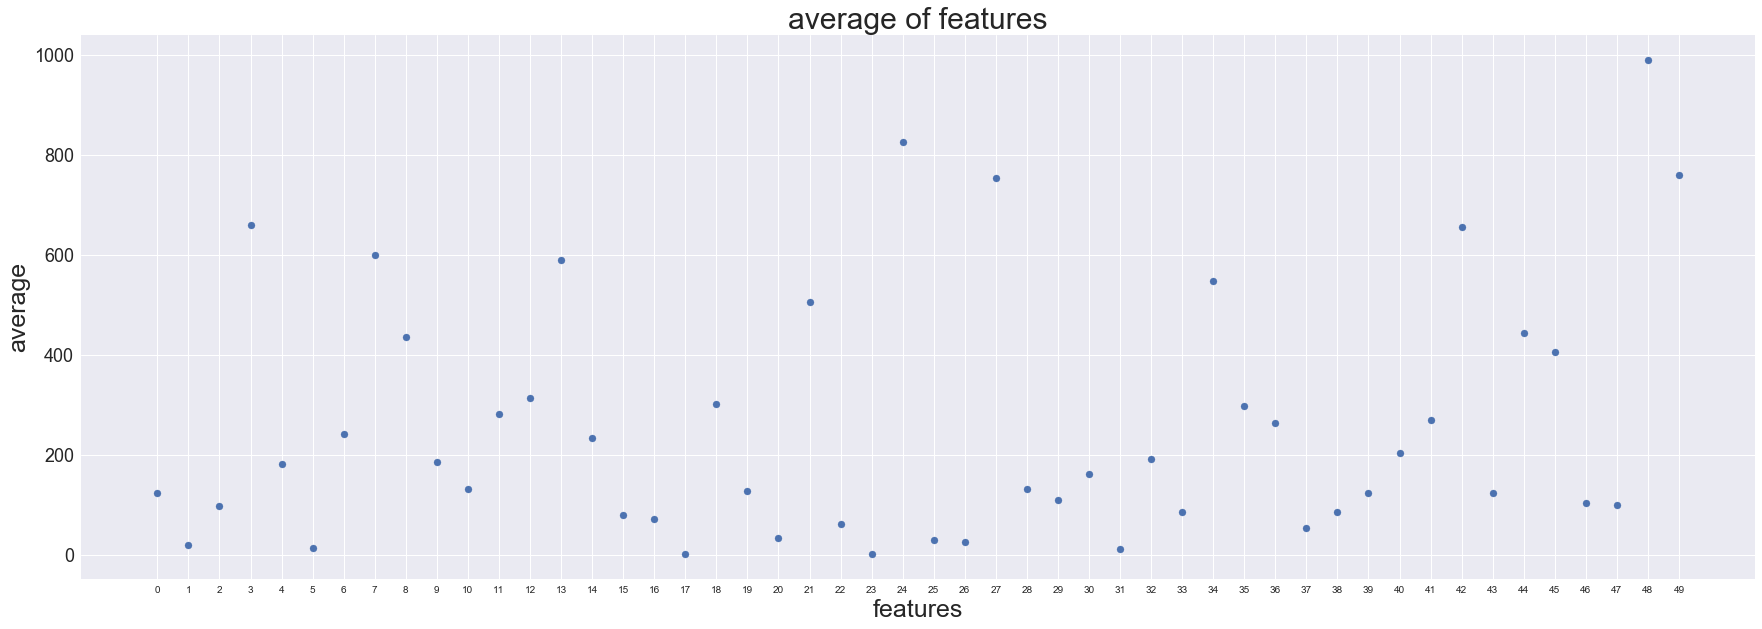

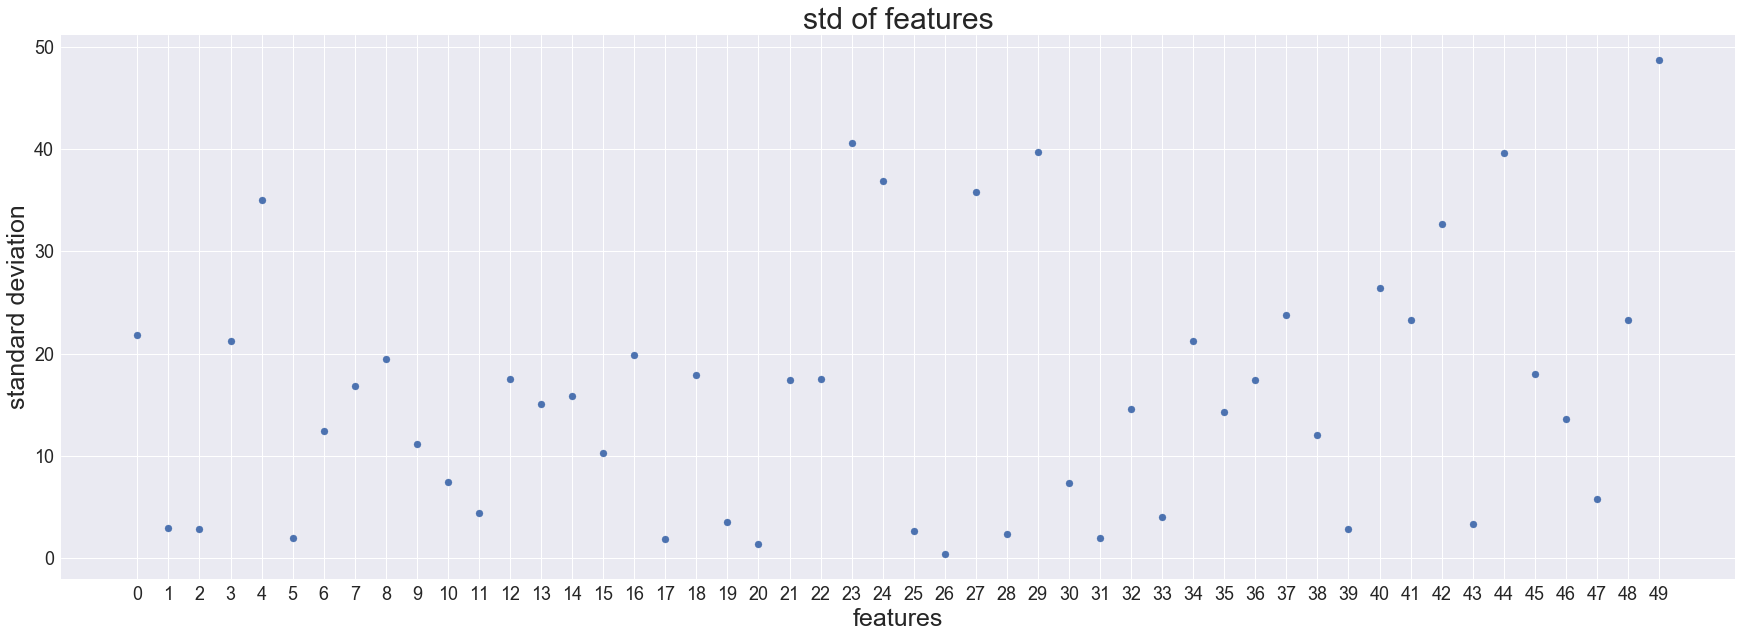

In [340]:
x_mean= x.mean(axis=0)
fig = plt.figure(figsize=[30,10])
plt.scatter(x=labels, y=x_mean)
plt.title('average of features', fontsize = 30)
plt.xlabel('features', fontsize = 25)
plt.ylabel('average', fontsize = 25)
plt.xticks(range(0,50), fontsize = 10)
plt.yticks(range(0, 1200, 200), fontsize = 18)
plt.show()

x_std= x.std(axis=0)
fig = plt.figure(figsize=[30,10])
plt.scatter(x = labels, y = x_std)
plt.title('std of features', fontsize = 30)
plt.xlabel('features', fontsize = 25)
plt.ylabel('standard deviation', fontsize = 25)
plt.xticks(range(0,50), fontsize = 18)
plt.yticks(range(0, 60, 10), fontsize = 18)
plt.show()

### We can see that some features have a large variance and some small, therefore we need to normalize the data before performing PCA (to prevent loading on the large variances)

## QQ Plots of 10 First Features

Feature 0


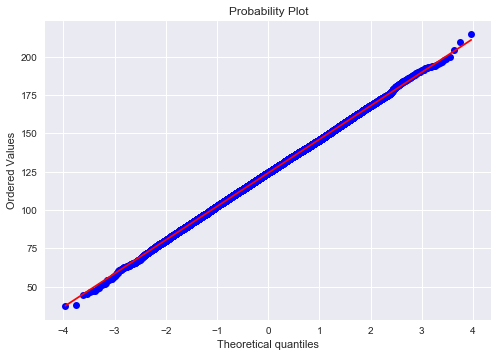

Feature 1


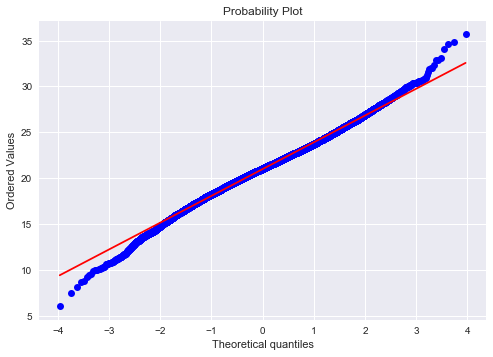

Feature 2


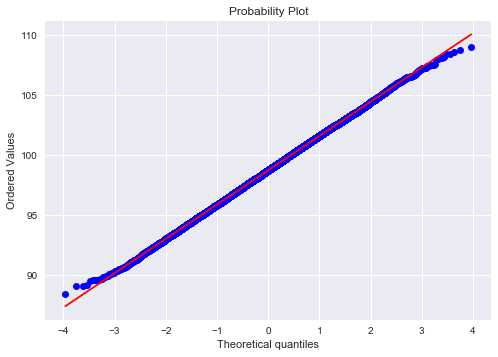

Feature 3


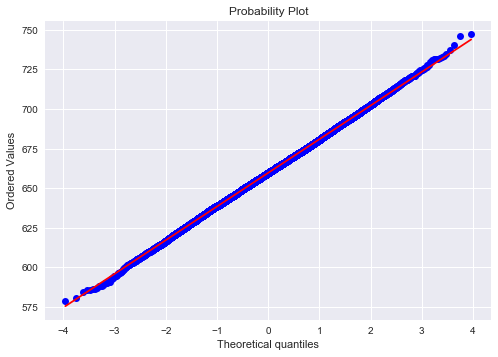

Feature 4


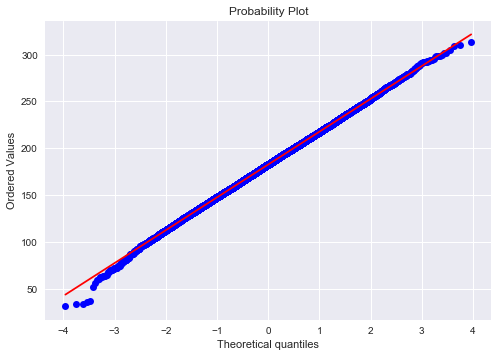

Feature 5


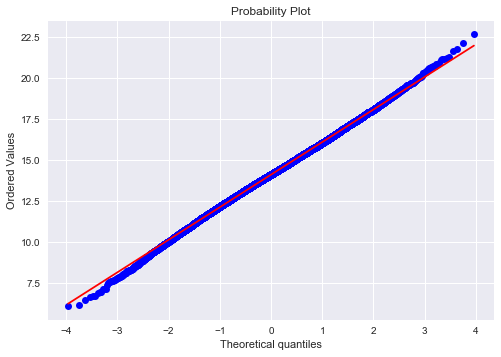

Feature 6


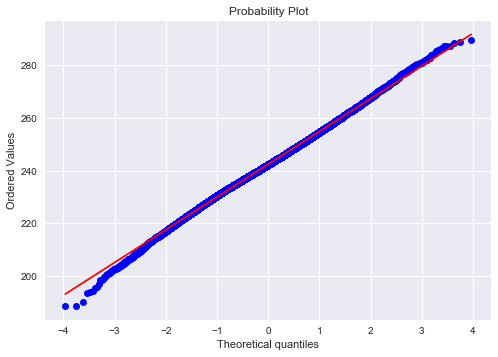

Feature 7


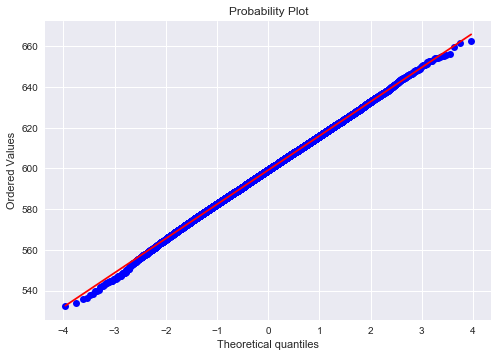

Feature 8


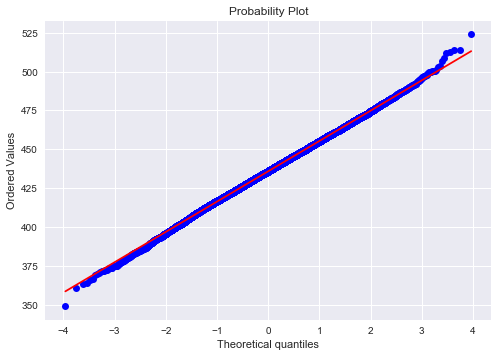

Feature 9


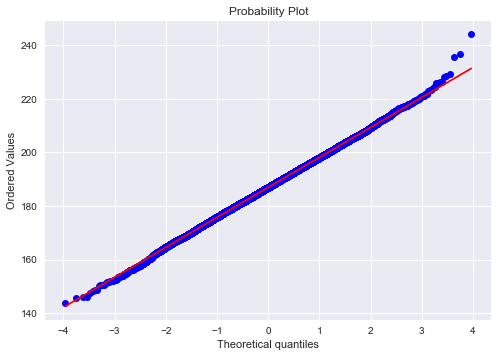

In [341]:
#QQplot - checking if the features have normal distribution 
for num in range(0, 10):
    print "Feature", num
    stats.probplot(x[:,num].reshape(-1), dist="norm", plot=pylab)
    plt.show()

### There is a linear fit of the data, so it can be assumed that the noise come from normal distribution.

## Correlation Matrix

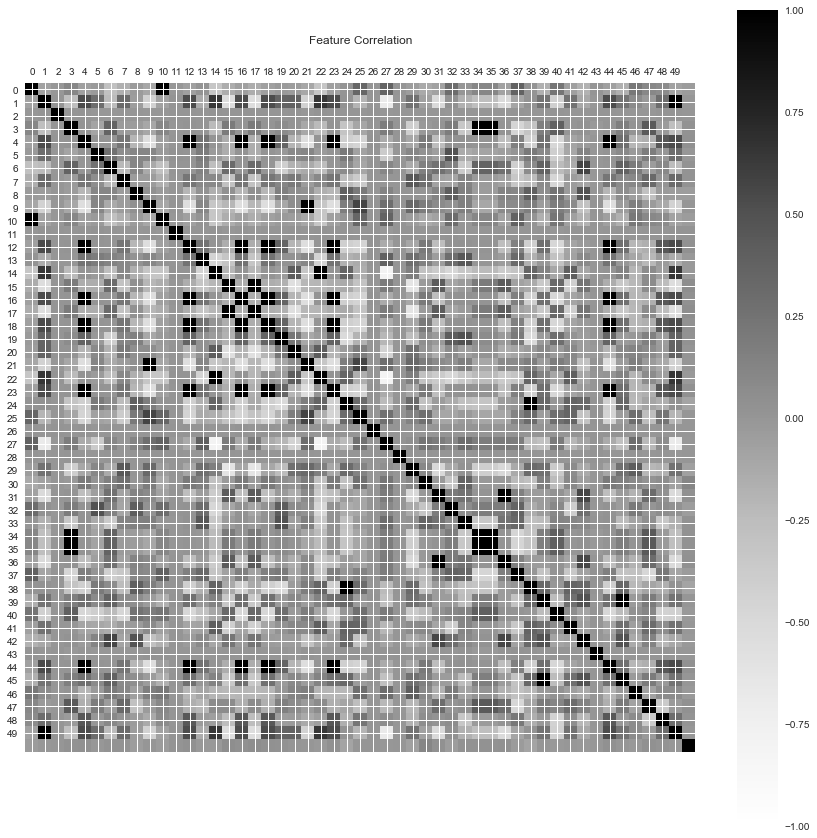

Correlated Features: ['10', '12', '16', '17', '18', '21', '22', '23', '34', '35', '36', '38', '44', '45', '49']


In [342]:
def correlation_matrix_plot (df):
    corr_matrix = df.corr()
    fig = plt.figure(figsize=[15,15])
    ax = fig.add_subplot(111)
    plt.title('Feature Correlation')
    cax = ax.matshow(corr_matrix, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, 50, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.show()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    if to_drop != []:
        print "Correlated Features:", to_drop
correlation_matrix_plot(df)

## Histograms of 10 First Features

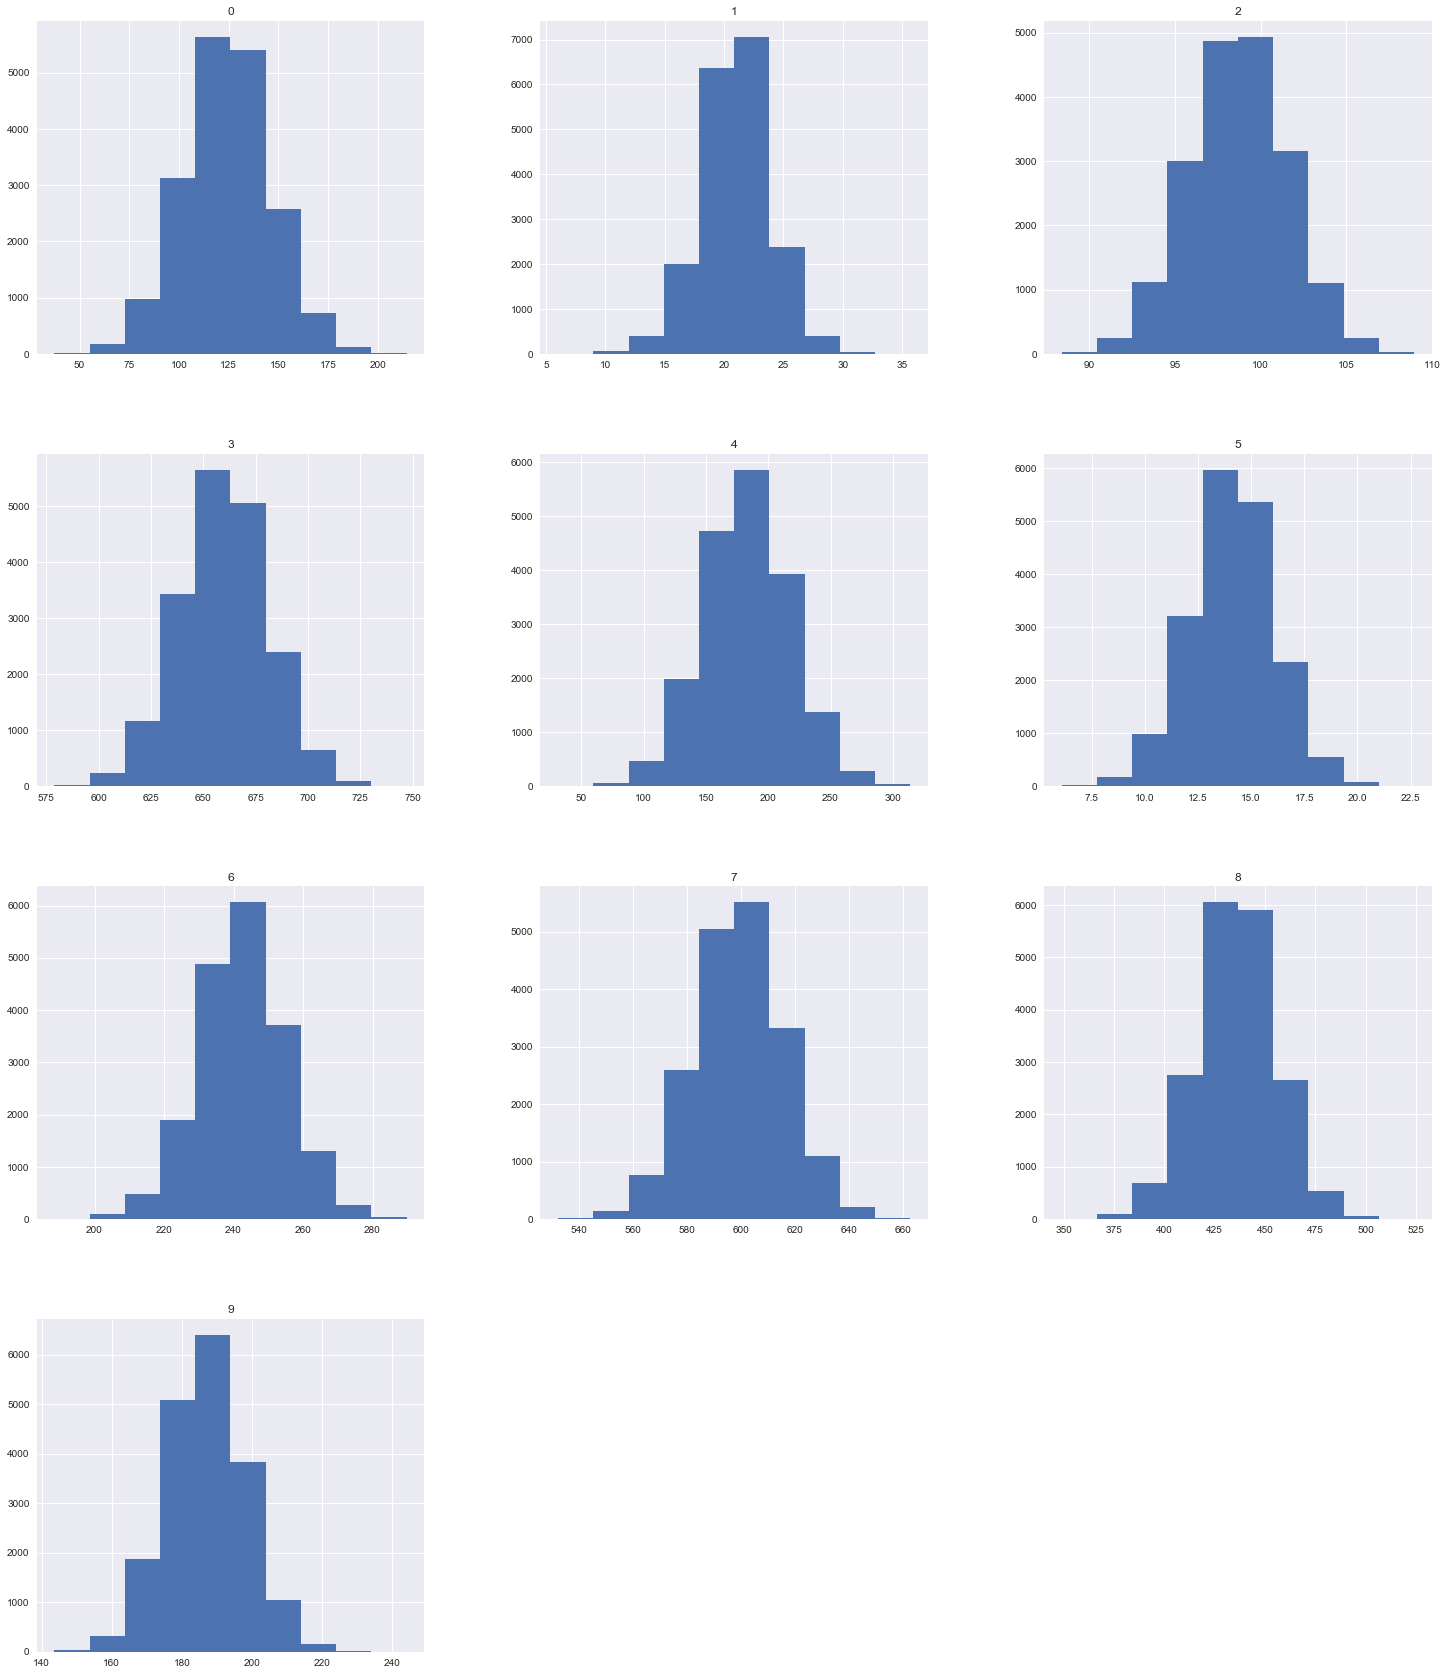

In [343]:
df[labels[0:10]].hist(figsize=[25,30])  # an example for first 10 histograms (gausian shape)
plt.show()

## Box Plots

FEATURE 0



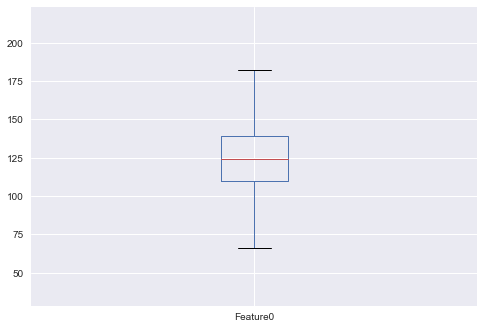

FEATURE 1



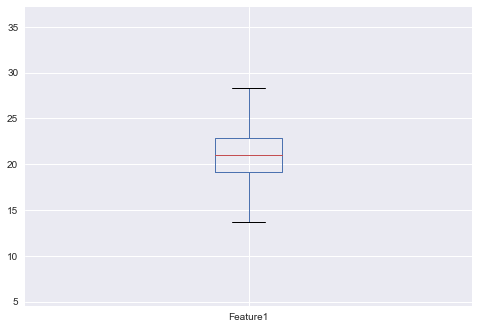

FEATURE 2



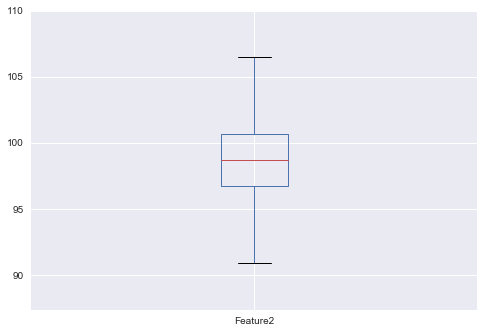

FEATURE 3



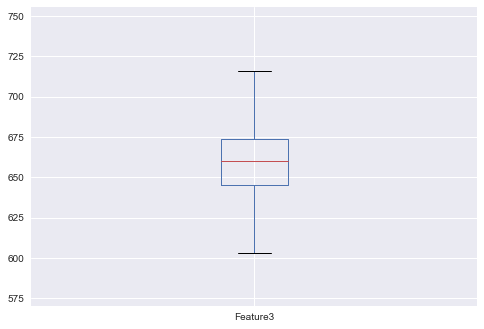

FEATURE 4



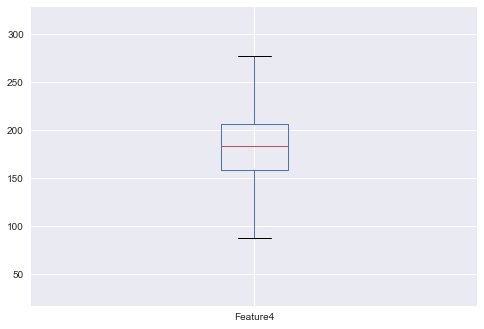

FEATURE 5



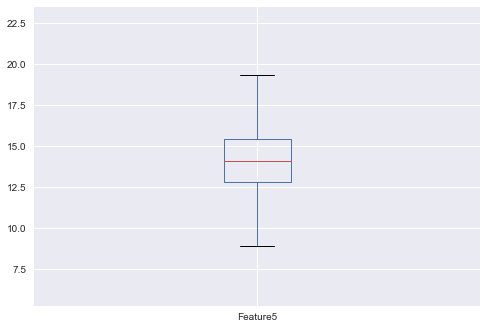

FEATURE 6



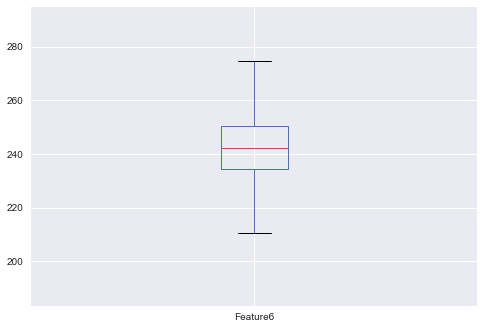

FEATURE 7



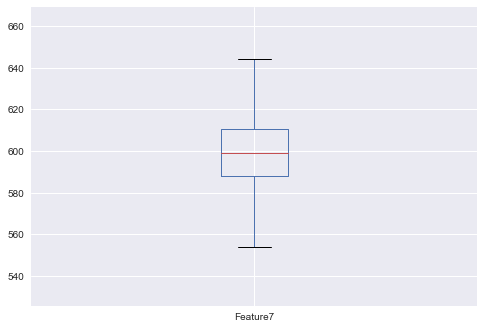

FEATURE 8



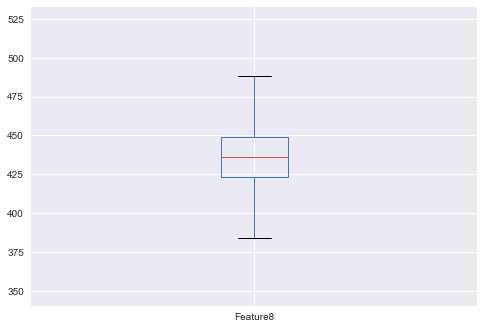

FEATURE 9



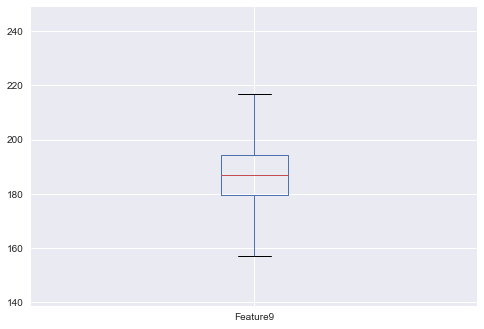

FEATURE 10



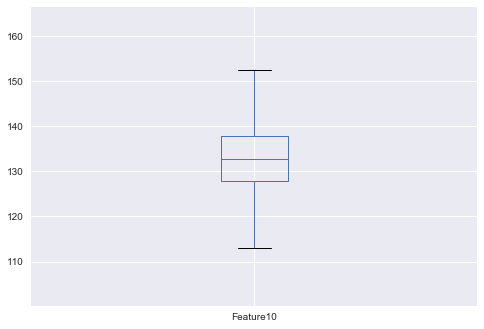

FEATURE 11



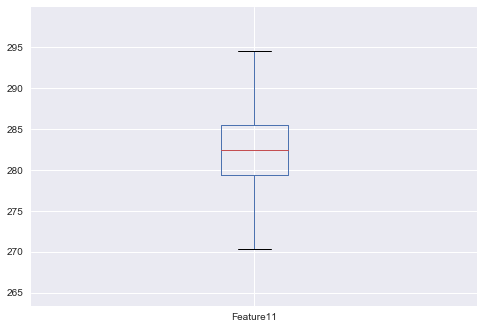

FEATURE 12



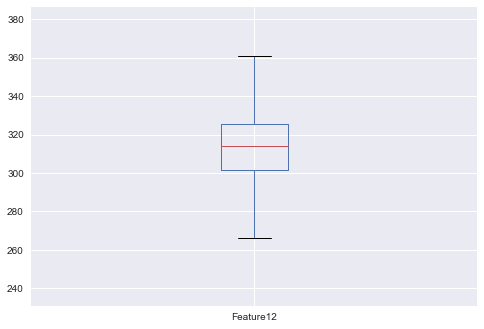

FEATURE 13



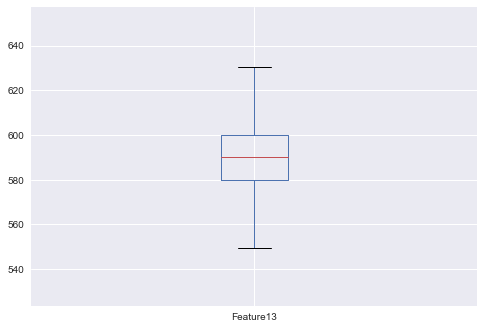

FEATURE 14



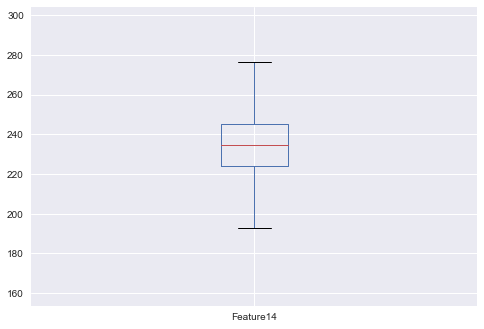

FEATURE 15



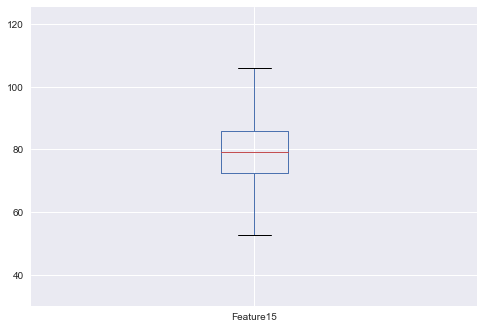

FEATURE 16



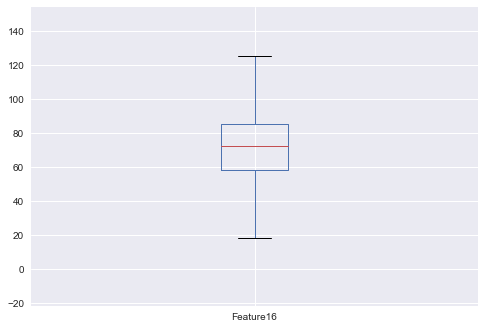

FEATURE 17



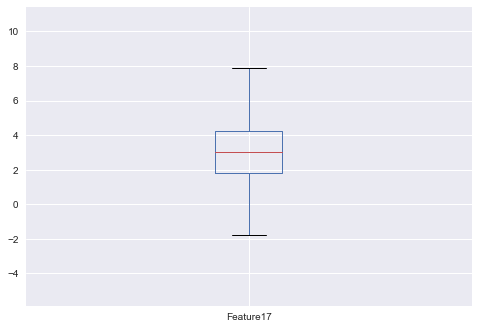

FEATURE 18



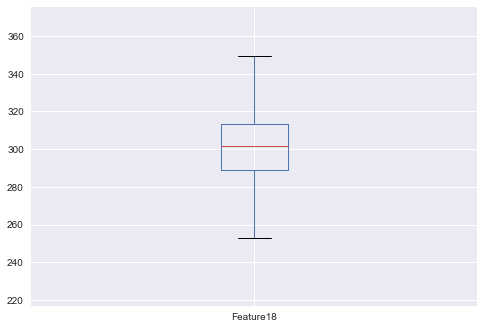

FEATURE 19



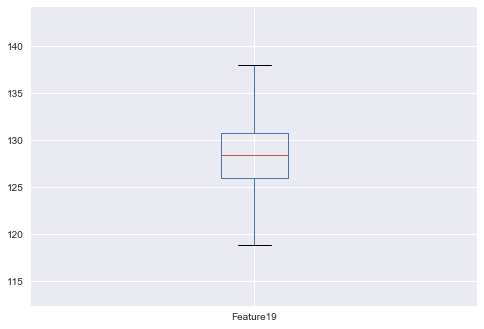

FEATURE 20



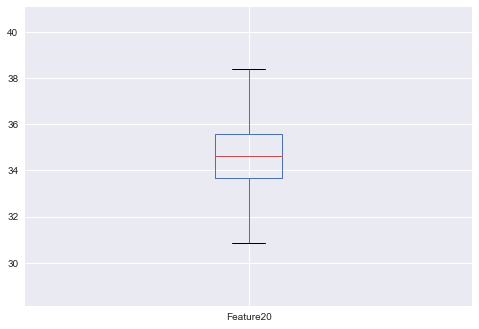

FEATURE 21



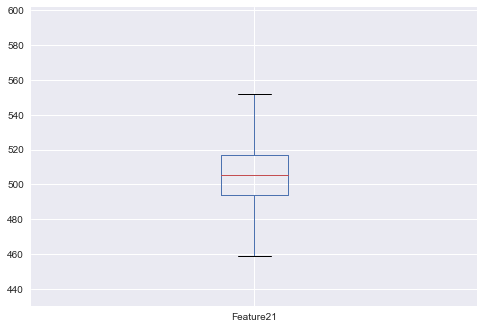

FEATURE 22



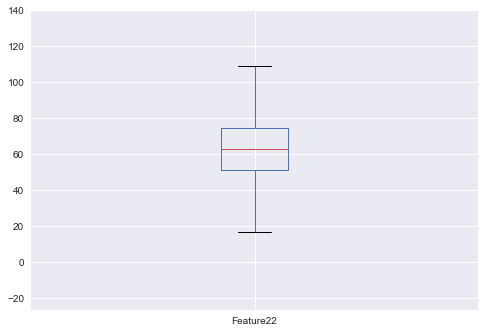

FEATURE 23



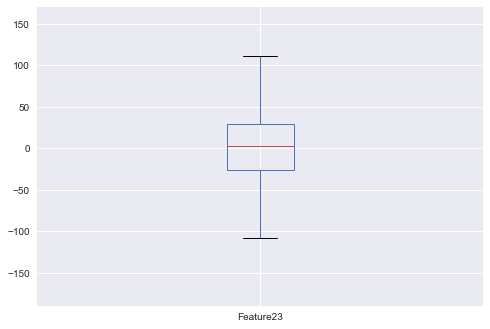

FEATURE 24



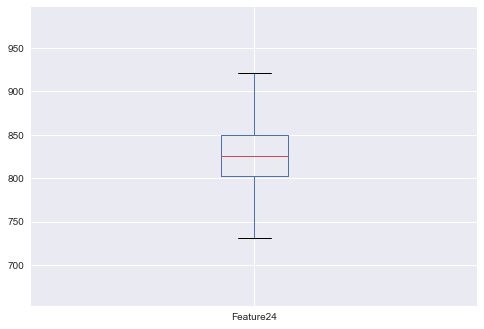

FEATURE 25



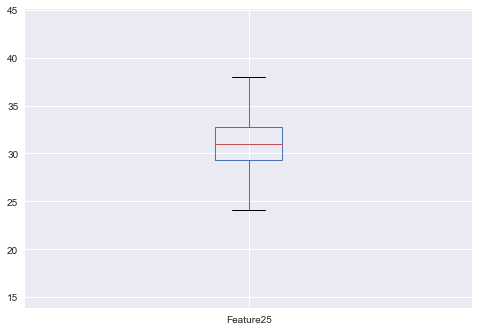

FEATURE 26



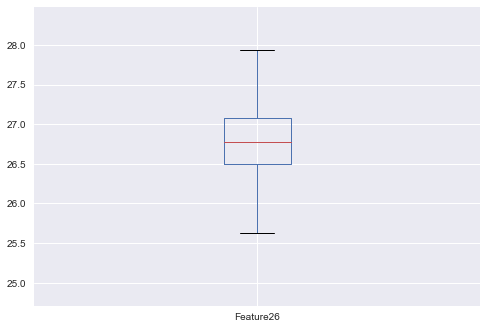

FEATURE 27



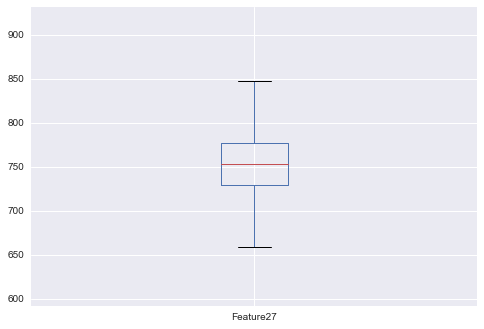

FEATURE 28



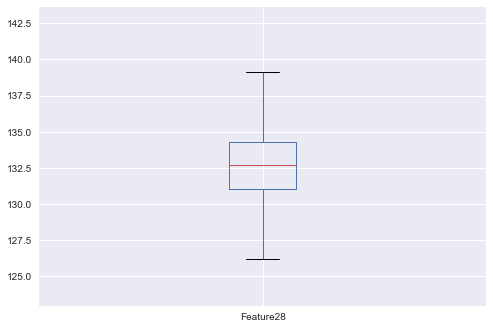

FEATURE 29



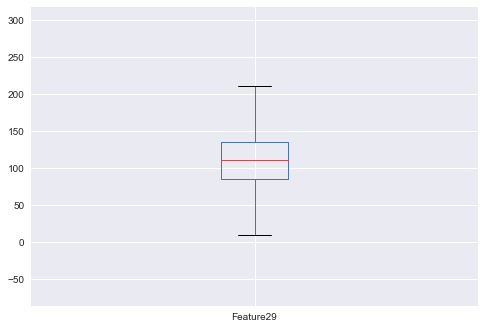

FEATURE 30



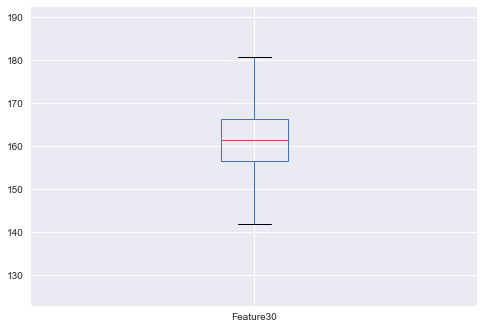

FEATURE 31



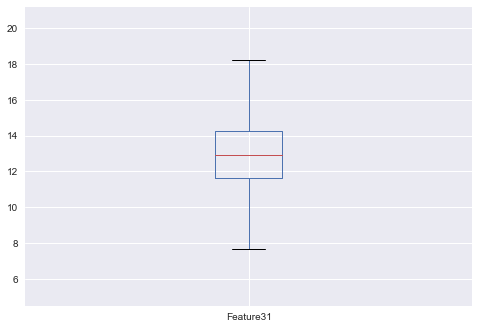

FEATURE 32



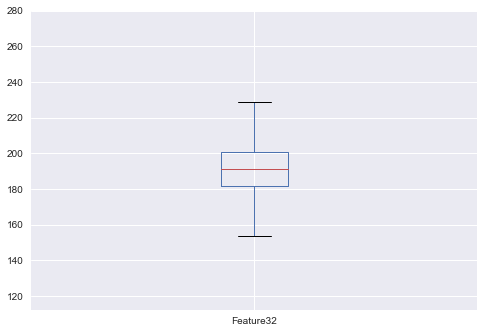

FEATURE 33



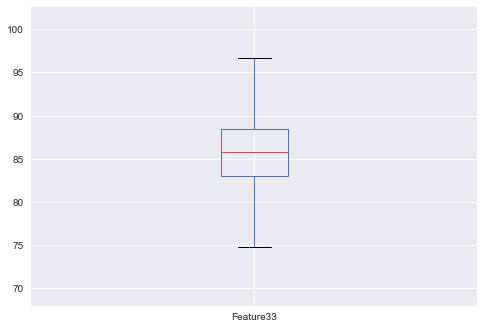

FEATURE 34



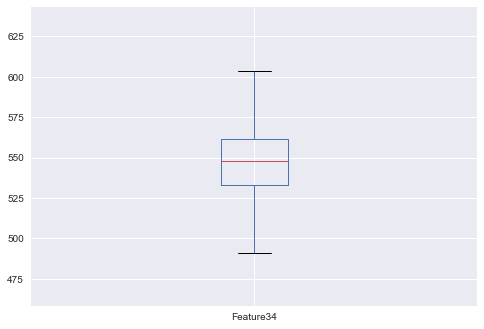

FEATURE 35



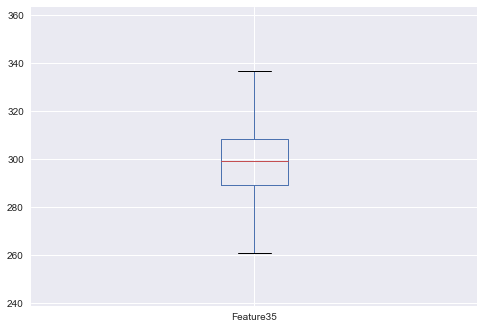

FEATURE 36



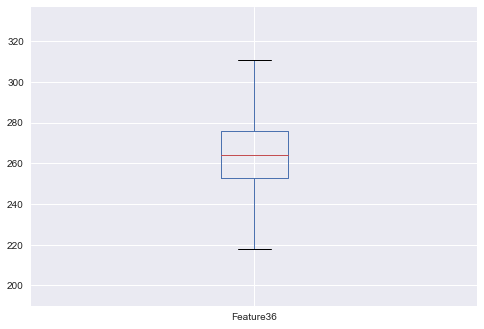

FEATURE 37



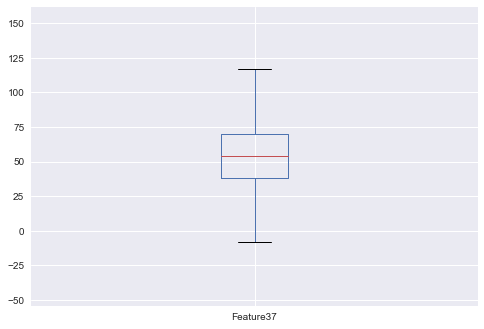

FEATURE 38



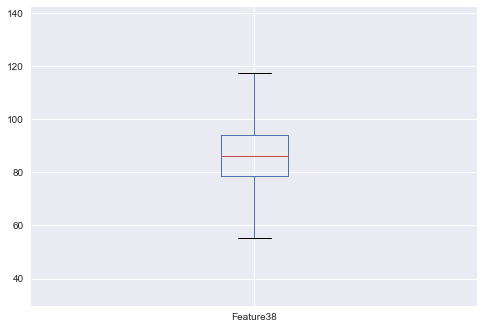

FEATURE 39



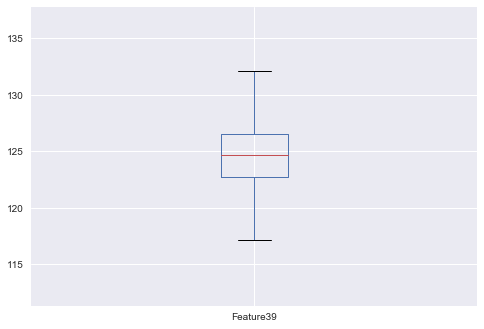

FEATURE 40



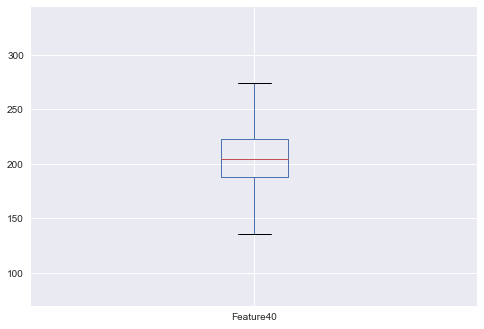

FEATURE 41



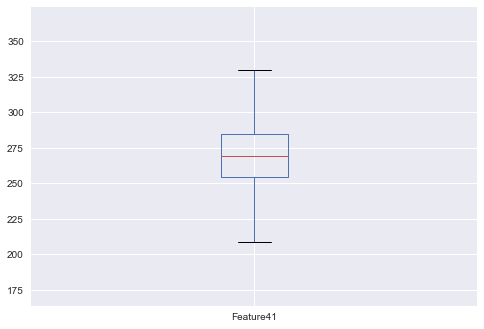

FEATURE 42



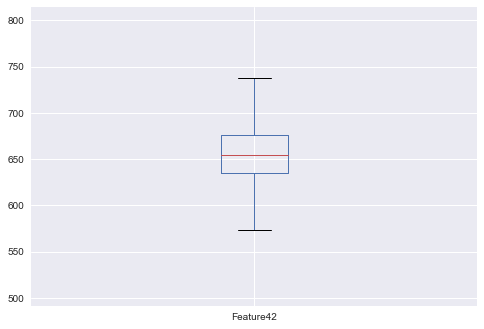

FEATURE 43



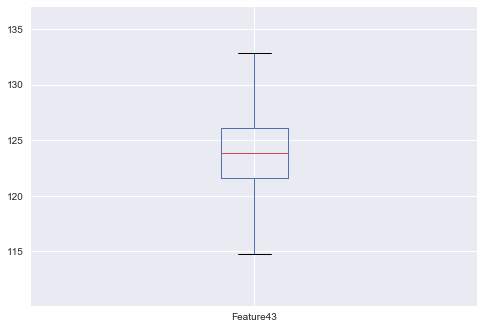

FEATURE 44



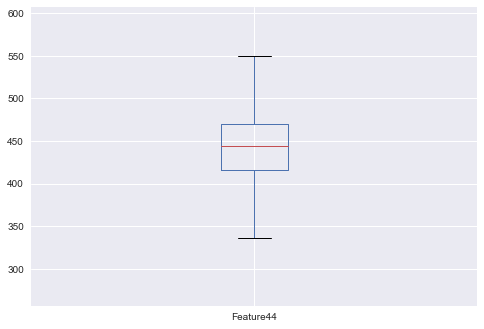

FEATURE 45



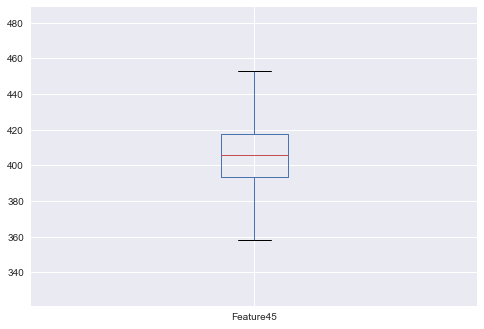

FEATURE 46



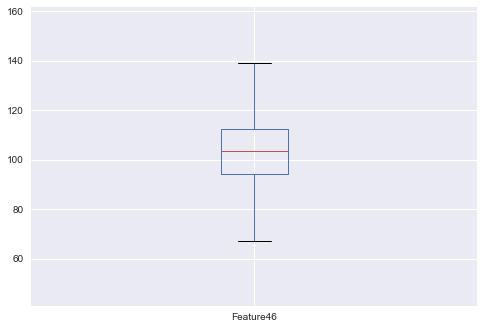

FEATURE 47



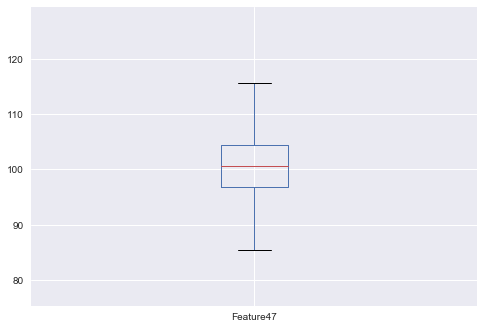

FEATURE 48



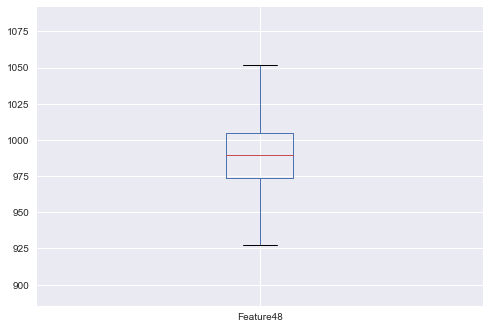

FEATURE 49



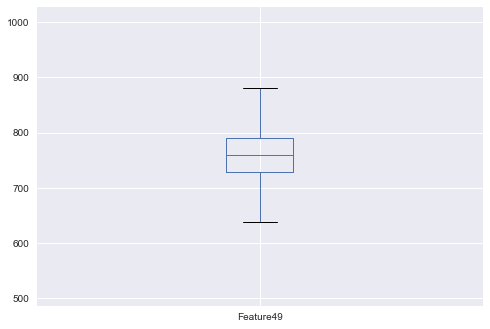

In [344]:
for i in range(df.shape[1]-1):
    Feature= df.values[:,i] # every iteration will be on the next column
    
    print "FEATURE " +str(i) +"\n"
    df_Feacher = pd.DataFrame(Feature[:], columns=['Feature'+str(i)])
    df_Feacher.plot.box()
    plt.show()

# Pre Processing

In [300]:
# checking if there is missing data
# let's drop the empty cells from our data
if df.dropna().shape == df.shape:
    print "there is no nan cells"
else:
    df = df.dropna()
    print "missing rows were removed"

there is no nan cells


## Outliers

In [301]:
def outliers_removal(df):
    return df[(np.abs(stats.zscore(df)) < 3).all(axis = 1)]
outliers_removal(df)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,label
0,113.826053,23.948854,102.056782,639.805607,175.989082,14.647313,234.234209,608.535919,446.819401,179.652794,...,296.534652,662.778245,122.104685,435.773642,388.982832,100.562818,102.125585,991.686565,808.343925,1.0
1,132.581695,22.638720,105.065020,680.557685,208.790800,13.128481,235.636045,600.176141,422.287947,178.507788,...,257.906415,656.460354,121.802943,472.841235,416.337204,95.028024,102.925133,993.711455,786.572251,1.0
2,121.761576,17.252453,99.865797,660.387165,184.793750,14.138956,241.661497,611.717245,412.798011,203.329685,...,227.861701,614.652505,126.480772,445.723360,394.625377,112.330478,101.073268,990.870465,697.063751,1.0
3,151.737753,18.341292,95.859642,679.888202,196.984576,14.563256,239.086842,576.034203,453.327214,194.079132,...,291.883312,648.289500,120.691429,459.499607,394.548179,90.471040,101.446145,1017.988768,715.157977,0.0
4,105.593099,19.977533,97.118952,690.762356,167.275781,16.041764,256.152953,588.069480,448.462187,183.840391,...,270.543414,672.446490,122.261714,425.927172,399.576197,88.352543,102.642183,983.383619,742.348887,0.0
5,174.255109,16.736054,101.540293,665.147365,178.114204,8.959407,221.123991,613.073763,452.720806,178.989141,...,209.160910,637.455742,126.292036,438.175137,367.662612,112.771679,95.920231,999.840960,688.482279,1.0
6,103.183205,19.593927,99.645307,657.576980,187.664203,14.865282,270.242817,566.508752,449.800284,179.377780,...,250.633074,701.446595,126.639597,448.967116,411.980907,101.702578,91.463229,1003.695881,735.974160,0.0
7,134.900650,15.902467,99.157280,650.344268,132.179755,11.929471,231.784850,599.924398,453.951407,201.448050,...,257.475607,669.314174,119.788162,386.266897,400.425233,103.287116,101.917784,965.263316,674.629814,1.0
8,152.951962,13.772085,93.351611,699.208770,126.618953,12.778016,251.793039,556.621628,442.678638,206.289656,...,257.867396,649.030757,124.050962,379.982911,394.554225,116.627172,99.995780,1002.222394,639.227327,0.0
9,97.335374,22.343299,100.555430,622.324641,212.367277,15.369765,247.790298,583.427332,425.505516,181.564998,...,254.570958,656.924923,124.249734,476.882834,389.367993,96.032757,93.355536,1017.048665,781.662974,0.0


## Data Normalization
### Let's check if our data is normalized, just by observing the difference between the columns.

In [302]:
x.max(axis = 0)

array([  214.48111195,    35.69000571,   108.95423012,   747.15815661,
         313.88820042,    22.66594321,   289.7713983 ,   662.68385211,
         523.97468716,   244.0315881 ,   163.51618313,   298.25246039,
         379.33577708,   651.25901824,   297.35640882,   121.22044265,
         146.3583709 ,    10.63574836,   368.2659653 ,   142.77471223,
          40.49643654,   594.19594813,   132.19530823,   153.96818206,
         981.93201134,    43.67923059,    28.30952066,   916.13772616,
         142.68816733,   299.51165885,   189.3083303 ,    20.42531133,
         272.24302888,   101.02207686,   634.95428875,   357.91747585,
         330.17820191,   152.14373481,   137.17547671,   136.5857339 ,
         331.42124459,   364.60336292,   799.91393779,   135.76534178,
         591.6065874 ,   481.35228463,   156.20990182,   126.89562642,
        1082.59540255,  1003.4573137 ])

In [303]:
x.min(axis = 0)

array([  37.28119698,    6.02411089,   88.40584118,  578.75612627,
         31.49337869,    6.09386558,  188.42273818,  532.30754673,
        349.04716303,  143.63603755,  103.18857174,  265.03634803,
        238.02052433,  529.62884043,  160.41445048,   34.38262663,
        -13.40429262,   -5.09444743,  224.15150663,  113.76552422,
         28.72642842,  438.01010746,  -18.92158907, -173.06072997,
        668.49296713,   15.28870193,   24.88068038,  607.27724328,
        123.91488969,  -67.46186898,  126.06544593,    5.25673734,
        119.88581088,   69.56642669,  466.58958204,  244.43178855,
        196.66554724,  -44.46939681,   34.86218982,  112.54330518,
         82.26074418,  173.46403676,  506.02621349,  111.3309079 ,
        272.48622282,  328.90695937,   46.41983276,   77.84542041,
        894.78666974,  510.47219743])

### Like in real life, data is not normalized. The difference can be easily demonstrated by using one of the scalers.

In [304]:
scaled_x = MinMaxScaler().fit(x).transform(x)

In [305]:
scaled_x.max(axis = 0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [306]:
scaled_x.min(axis = 0)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Dimensions Reduction
### What about the dimensions of the problem? first we'll explore how many features are really needed for explaining most of the variance in our data.

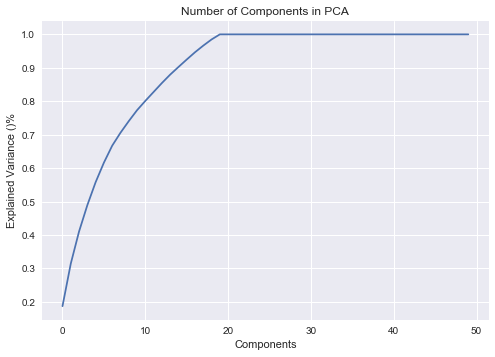

In [307]:
def find_n_components (x_train, plot = False):
    pca = PCA().fit(x_train)
    if plot:
        plt.figure(300)
        plt.title("Number of Components in PCA")
        plt.xlabel('Components')
        plt.ylabel('Explained Variance ()%')
        plt.plot(pca.explained_variance_ratio_.cumsum())
        plt.show()
        return
    return np.sum(pca.explained_variance_ratio_.cumsum() < 0.9999) + 1
find_n_components(scaled_x, True)

### 20 features are enough to explain 99.99% of the variance, which means dimensions can get "shrinked" easily.
### Going even more deeper, we'll get rid of all the correlated features and present only the features that matter.

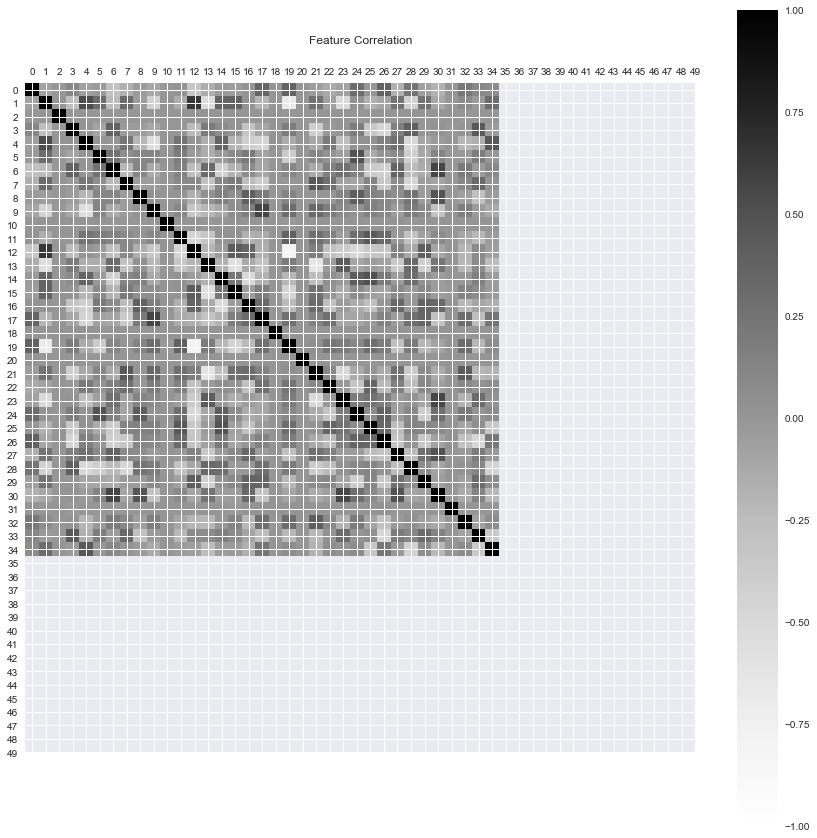

In [308]:
def correlations_detector (x_train):
    df = pd.DataFrame(x_train)
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    correlations = [column for column in upper.columns if any(upper[column] > 0.95)]
    return correlations

def correlations_removal (x_train, correlations):
    df = pd.DataFrame(x_train)
    return df.drop(df[correlations], axis=1)
    #return np.array(df.drop(df.columns[df.corr().abs().sum().argmax()],1))
correlation_matrix_plot(correlations_removal(x, correlations_detector(x)))

# Evaluation

In [309]:
# Adopted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def confusion_matrix_plot(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(round(cm[i, j],2)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [310]:
def Kfold_AUC (x, y, data_scaler, data_reducer, clf, k = 5, plot = False):
    # the function plots a graph for a given clf model, using Kfold
    clf_title = str(clf)[:str(clf).find("(")]
    cnf_matrix = np.zeros((2, 2)) # null confusion matrix
    Kfold = KFold(k, shuffle = False) 
    
    avg_fpr_test = np.linspace(0, 1, 100)   # the X axis (average fpr)
    avg_tpr_test = np.linspace(0, 1, 100)   # the Y axis (average tpr)
    
    avg_fpr_train = np.linspace(0, 1, 100)
    avg_tpr_train = np.linspace(0, 1, 100)
    
    tprs_test = np.linspace(0, 0, 100)
    tprs_train = np.linspace(0, 0, 100)
    
    confusion_indicator = 1
 
    # going through K iterations
    # each iteration handles different (K)% data for test and (1-K)% data for train

    for train_index, validation_index in Kfold.split(x):
        # ------------------------------ Data Split ----------------------------------
        x_train, y_train, x_validation, y_validation = x[train_index], y[train_index], x[validation_index], y[validation_index]
        
        # ---------------------------- Pre Processing --------------------------------
        # STAGE 1 - OUTLIERES REMOVAL
        original_df = pd.DataFrame(x_train).assign(label = y_train)
        clean_df = outliers_removal(original_df)
        x_train, y_train = clean_df.values[:,:-1], clean_df.values[:,-1]
        
        # STAGE 2 - SCALING
        data_scaler.fit(x_train)
        x_train = data_scaler.transform(x_train)
        x_validation = data_scaler.transform(x_validation)
        
        # STAGE 3 - DIMENSIONAL REDUCTION
        # STAGE 3.1 - CORRELATIONS REMOVAL
        if data_reducer is None:
            correlations = correlations_detector(x_train)
            x_train = correlations_removal(x_train, correlations).values[:,:]
            x_validation = correlations_removal(x_validation, correlations).values[:,:]
        
        else:
            # STAGE 3.2 - PCA (Performed Anyway)
            pca = PCA(find_n_components(x), random_state = 1).fit(x_train)
            x_train = pca.transform(x_train)
            x_validation = pca.transform(x_validation)
            
            # STAGE 3.3 - LDA
            if isinstance(data_reducer, LinearDiscriminantAnalysis):
                data_reducer.fit(x_train, y_train)
                data_reducer.transform(x_train)
                data_reducer.transform(x_validation)
        
        # ---------------------------- Classifier Model --------------------------------        
        # STAGE 4 - FITTING THE CLASSIFIER MODEL
        clf.fit(x_train, y_train)
        
        # STAGE 5 - PREDICTING
        # predicting the test probabilities to "1" (=Positive) according to the our trained classifier model
        y_predict_test = clf.predict_proba(x_validation)[:, 1]
        y_predict_train = clf.predict_proba(x_train)[:, 1]
        
        # exploiting relavent measures for the graph, by comparing real and predicted test labels
        fpr_test, tpr_test, thresholds_test = roc_curve(y_validation, y_predict_test)
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_predict_train)
        
        # adding the interpulated tpr of the current iteration, for the yet to come (for calculating the average)
        tprs_test += interp(avg_fpr_test, fpr_test, tpr_test)
        tprs_train += interp(avg_fpr_train, fpr_train, tpr_train)
        
        # updating confusion matrix due to the first fold results
        if confusion_indicator == 1:
            cnf_matrix+= confusion_matrix(y_validation, clf.predict(x_validation))
            confusion_indicator+=1
            
        # resetting the first tpr to zero again, before the next iteration
        tprs_test [0] = 0.0
        tprs_train [0] = 0.0
    
    avg_tpr_test[:-1] = tprs_test[:-1]/k
    avg_auc_test = auc(avg_fpr_test, avg_tpr_test)
    
    avg_tpr_train[:-1] = tprs_train[:-1]/k
    avg_auc_train = auc(avg_fpr_train, avg_tpr_train)

    if plot:
        # adding the K-folds label to the legend
        plt.plot([0], [0], color='#D3D3D3', linestyle='-', label='K-folds')    
        # adding the average tpr (of interpulated tprs) and average auc to the plotted graph (coloured respectively in red and navy)
        plt.plot(avg_fpr_test, avg_tpr_test, color = 'red', linestyle ='-', label = 'Mean ROC ' + '(AUC = ' + "{:.3f}".format(avg_auc_test) + ')')
        plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
        plt.title('ROC for ' + clf_title)
        plt.xlabel('False Positive Rate')        
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()
        confusion_matrix_plot(cnf_matrix, classes=['class_0', 'class_1'])
    return avg_auc_test, avg_auc_train

# Exploring Classifier Models

In [311]:
data_scalers = {"Standard Scaler": StandardScaler(), "Min Max Scaler": MinMaxScaler()}
data_reducers = {"PCA": PCA(), "LDA": LinearDiscriminantAnalysis(), "Correlations Removal": None}

In [312]:
print x.shape
print y.shape

(18750L, 50L)
(18750L,)


## KNN

In [313]:
knn_k_models = []
for k in range(1, 718, 2):
    clf = neighbors.KNeighborsClassifier(n_neighbors = k, weights = "uniform", metric = "manhattan", algorithm = "auto")
    """""
    auc_test, auc_train = Kfold_AUC(pca(standard_scaler(x)), y, clf, k = 5, plot = False)
    model = OrderedDict()
    model["k"] = k
    model["AUC (test)"] = auc_test
    model["AUC (train)"] = auc_train
    model["overfitting"] = abs(auc_train - auc_test) > 0.02
    knn_k_models.append(model)
    """""
"""""
knn_k_models_df = pd.DataFrame(knn_k_models)
display(HTML(knn_k_models_df.to_html()))
"""""
display(HTML(k_results.to_html()))

,k,AUC (test),AUC (train),overfitting
13,27,0.936476,0.951680,False
14,29,0.936461,0.950950,False
21,43,0.936394,0.948173,False
25,51,0.936261,0.946514,False
15,31,0.936241,0.950561,False
18,37,0.936214,0.949194,False
12,25,0.936176,0.952553,False
20,41,0.936088,0.948471,False
17,35,0.936049,0.949593,False
23,47,0.935989,0.947321,False


In [314]:
knn = {"metric": ["manhattan", "euclidean", "chebyshev"], \
       "algorithm": ["auto"], \
       "weights": ["uniform", "distance"]}
knn_models = []
#last_auc = 0
for normalization_option in data_scalers:
    for dimensional_reduction_option in data_reducers:
        for weights in knn["weights"]:
            for metric in knn["metric"]:
                for algorithm in knn["algorithm"]:
                    for k in [27, 29, 43, 51, 31]:
                        data_scaler = data_scalers[normalization_option]
                        data_reducer = data_reducers[dimensional_reduction_option]
                        clf = neighbors.KNeighborsClassifier(n_neighbors = k, \
                                                             weights = weights, \
                                                             metric = metric, \
                                                             algorithm = algorithm)
                        """""
                        auc_test, auc_train = Kfold_AUC(x, y, data_scaler, data_reducer, clf)
                        #if abs(auc_test - last_auc) < 0.01:  # parameters don't affect much results
                        #    break
                        #last_auc = auc_test
                        model = OrderedDict()
                        model["Data Normalization"] = normalization_option
                        model["Dimensional Reduction"] = dimensional_reduction_option
                        model["k"] = k
                        model["weights"] = weights
                        model["metric"] = metric
                        model["algorithm"] = algorithm
                        model["AUC (test)"] = auc_test
                        model["AUC (train)"] = auc_train
                        model["overfitting"] = abs(auc_train - auc_test) > 0.02
                        knn_models.append(model)
                        """""
                        
"""""
knn_models_df = pd.DataFrame(knn_models)
display(HTML(knn_models_df.to_html()))
"""""
display(HTML(knn_results.to_html()))

,Data Normalization,Dimensional Reduction,k,weights,metric,algorithm,AUC (test),AUC (train),overfitting
165,Standard Scaler,Correlations Removal,27,distance,manhattan,auto,0.943498,0.994949,True
166,Standard Scaler,Correlations Removal,29,distance,manhattan,auto,0.943237,0.994949,True
169,Standard Scaler,Correlations Removal,31,distance,manhattan,auto,0.942953,0.994949,True
75,Min Max Scaler,Correlations Removal,27,distance,manhattan,auto,0.942621,0.994949,True
76,Min Max Scaler,Correlations Removal,29,distance,manhattan,auto,0.942521,0.994949,True
79,Min Max Scaler,Correlations Removal,31,distance,manhattan,auto,0.942379,0.994949,True
167,Standard Scaler,Correlations Removal,43,distance,manhattan,auto,0.941492,0.994949,True
77,Min Max Scaler,Correlations Removal,43,distance,manhattan,auto,0.941236,0.994949,True
170,Standard Scaler,Correlations Removal,27,distance,euclidean,auto,0.940961,0.994949,True
150,Standard Scaler,Correlations Removal,27,uniform,manhattan,auto,0.940801,0.949440,False


In [315]:
print x.shape
print y.shape

(18750L, 50L)
(18750L,)


## Naive Bayes

In [316]:
naive_bayes_models = []
#last_auc = 0
for normalization_option in data_scalers:
    for dimensional_reduction_option in data_reducers:
        data_scaler = data_scalers[normalization_option]
        data_reducer = data_reducers[dimensional_reduction_option]
        clf = GaussianNB(priors = None)
        auc_test, auc_train = Kfold_AUC(x, y, data_scaler, data_reducer, clf)
        #if abs(auc_test - last_auc) < 0.01:  # parameters don't affect much results
        #    break
        #last_auc = auc_test        
        model = OrderedDict()
        model["Data Normalization"] = normalization_option
        model["Dimensional Reduction"] = dimensional_reduction_option
        model["priors"] = None        
        model["AUC (test)"] = auc_test
        model["AUC (train)"] = auc_train
        model["overfitting"] = abs(auc_train - auc_test) > 0.02
        naive_bayes_models.append(model)
naive_bayes_models_df = pd.DataFrame(naive_bayes_models)
display(HTML(naive_bayes_models_df.to_html()))

,Data Normalization,Dimensional Reduction,priors,AUC (test),AUC (train),overfitting
0,Min Max Scaler,LDA,None,0.673773,0.676795,False
1,Min Max Scaler,PCA,None,0.673773,0.676795,False
2,Min Max Scaler,Correlations Removal,None,0.710759,0.701339,False
3,Standard Scaler,LDA,None,0.677735,0.680559,False
4,Standard Scaler,PCA,None,0.677735,0.680559,False
5,Standard Scaler,Correlations Removal,None,0.710759,0.701339,False


### Neural Network

In [317]:
neural_network = {"activation": ["relu"],
                  "hidden layer sizes": [(50, 100), (100, 150)], \
                  "batch size": [100, 20], \
                  "learning rate": ["constant", "adaptive"], \
                  "learning rate init": [0.1, 0.01], \
                  "alpha": [0.1, 0.01]}
neural_network_models = []
auc_test = 0
auc_train = 0
#last_auc = 0

for normalization_option in data_scalers:
    for dimensional_reduction_option in data_reducers:
        for activation in neural_network["activation"]:
            for hidden_layer_size in neural_network["hidden layer sizes"]:
                for batch_size in neural_network["batch size"]:
                    for learning_rate in neural_network["learning rate"]:
                        for learning_rate_init in neural_network["learning rate init"]:
                            for alpha in neural_network["alpha"]:
                                data_scaler = data_scalers[normalization_option]
                                data_reducer = data_reducers[dimensional_reduction_option]
                                clf = MLPClassifier(activation = activation, \
                                                    hidden_layer_sizes = hidden_layer_size, \
                                                    alpha = alpha, \
                                                    solver = "sgd", \
                                                    learning_rate_init = learning_rate_init, 
                                                    learning_rate = learning_rate, 
                                                    power_t = 0.5, \
                                                    early_stopping = False, \
                                                    tol = 1e-4, \
                                                    warm_start = False, \
                                                    batch_size = batch_size, \
                                                    max_iter = 500)
                                """""
                                auc_test, auc_train = Kfold_AUC(x, y, data_scaler, data_reducer, clf)
                                #if abs(auc_test - last_auc) < 0.01:  # parameters don't affect much results
                                #    break
                                #last_auc = auc_test
                                model = OrderedDict()
                                model["Data Normalization"] = normalization_option
                                model["Dimensional Reduction"] = dimensional_reduction_option
                                model["activation"] = activation
                                model["hidden layer size"] = hidden_layer_size
                                model["batch size"] = batch_size
                                model["learning rate"] = learning_rate
                                model["learning rate init"] = learning_rate_init
                                model["alpha"] = alpha
                                model["AUC (test)"] = auc_test
                                model["AUC (train)"] = auc_train
                                model["overfitting"] = abs(auc_train - auc_test) > 0.02
                                neural_network_models.append(model)
                                """""
"""""
neural_network_models_df = pd.DataFrame(neural_network_models)
display(HTML(neural_network_models_df.to_html()))
"""""
display(HTML(neural_network_results.to_html()))

,Data Normalization,Dimensional Reduction,activation,hidden layer size,batch size,learning rate,learning rate init,alpha,AUC (test),AUC (train),overfitting
180,Standard Scaler,Correlations Removal,relu,"(100, 150)",100,adaptive,0.10,0.10,0.988318,0.994708,False
116,Standard Scaler,LDA,relu,"(100, 150)",100,adaptive,0.10,0.10,0.988241,0.994831,False
148,Standard Scaler,PCA,relu,"(100, 150)",100,adaptive,0.10,0.10,0.988086,0.994841,False
164,Standard Scaler,Correlations Removal,relu,"(50, 100)",100,adaptive,0.10,0.10,0.987380,0.994176,False
132,Standard Scaler,PCA,relu,"(50, 100)",100,adaptive,0.10,0.10,0.986712,0.994459,False
191,Standard Scaler,Correlations Removal,relu,"(100, 150)",20,adaptive,0.01,0.01,0.986603,0.994949,False
100,Standard Scaler,LDA,relu,"(50, 100)",100,adaptive,0.10,0.10,0.986424,0.994458,False
159,Standard Scaler,PCA,relu,"(100, 150)",20,adaptive,0.01,0.01,0.986082,0.994949,False
127,Standard Scaler,LDA,relu,"(100, 150)",20,adaptive,0.01,0.01,0.985998,0.994949,False
175,Standard Scaler,Correlations Removal,relu,"(50, 100)",20,adaptive,0.01,0.01,0.984996,0.994885,False


### Adaptive Boosting

In [318]:
adaptive_boosting = {"max depth": [2, 3, 4, 5, 6, 7], \
                     "n estimators": [300, 400, 450, 600]}
adaptive_boosting_models = []
#last_auc = 0
for normalization_option in data_scalers:
    for dimensional_reduction_option in data_reducers:
        for max_depth in adaptive_boosting["max depth"]:
            for n_estimators in adaptive_boosting["n estimators"]:
                data_scaler = data_scalers[normalization_option]
                data_reducer = data_reducers[dimensional_reduction_option]
                clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = max_depth), \
                                         n_estimators = n_estimators, \
                                         algorithm = "SAMME")
                """""
                auc_test, auc_train = Kfold_AUC (x, y, data_scaler, data_reducer, clf)
                #if abs(auc_test - last_auc) < 0.01:  # parameters don't affect much results
                #    break
                #last_auc = auc_test
                model = OrderedDict()
                model["Data Normalization"] = normalization_option
                model["Dimensional Reduction"] =  dimensional_reduction_option
                model["base estimator"] = "DecisionTreeClassifier"
                model["max depth"] = max_depth
                model["n estimators"] = n_estimators
                model["AUC (test)"] = auc_test
                model["AUC (train)"] = auc_train
                model["overfitting"] = abs(auc_train - auc_test) > 0.02
                adaptive_boosting_models.append(model)
                """""
"""""
adaptive_boosting_models_df = pd.DataFrame(adaptive_boosting_models)
display(HTML(adaptive_boosting_models_df.to_html()))
"""""
display(HTML(adaptive_boosting_results.to_html()))

,Data Normalization,Dimensional Reduction,base estimator,max depth,n estimators,AUC (test),AUC (train),overfitting
26,Min Max Scaler,Correlations Removal,DecisionTreeClassifier,4,600,0.928459,0.994395,True
25,Min Max Scaler,Correlations Removal,DecisionTreeClassifier,4,450,0.925263,0.992709,True
24,Min Max Scaler,Correlations Removal,DecisionTreeClassifier,4,300,0.921322,0.989065,True
35,Standard Scaler,LDA,DecisionTreeClassifier,4,600,0.906124,0.987742,True
43,Standard Scaler,PCA,DecisionTreeClassifier,4,450,0.905187,0.984267,True
34,Standard Scaler,LDA,DecisionTreeClassifier,4,450,0.905156,0.984267,True
23,Min Max Scaler,Correlations Removal,DecisionTreeClassifier,3,600,0.904247,0.964333,True
8,Min Max Scaler,LDA,DecisionTreeClassifier,4,600,0.903102,0.988214,True
17,Min Max Scaler,PCA,DecisionTreeClassifier,4,600,0.903096,0.988214,True
22,Min Max Scaler,Correlations Removal,DecisionTreeClassifier,3,450,0.902601,0.959657,True


# The Highest AUC Models

## Gaussian Naive Bayes

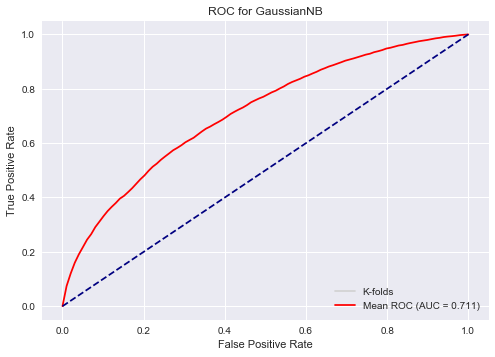

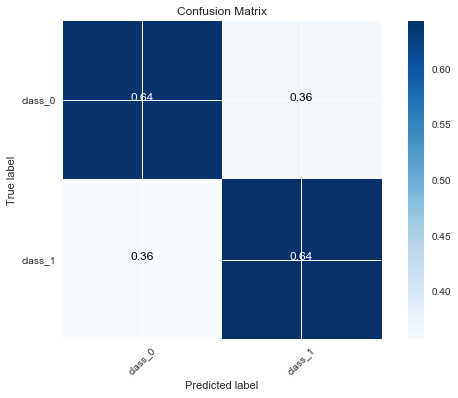

In [319]:
d_auc = {}
data_scaler = data_scalers["Standard Scaler"]
data_reducer = data_reducers["Correlations Removal"]
clf = GaussianNB(priors = None)
d_auc["GaussianNB"] = Kfold_AUC(x, y, data_scaler, data_reducer, clf, plot = True)[0]

## KNN

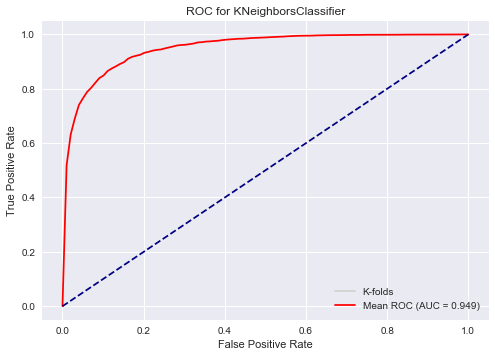

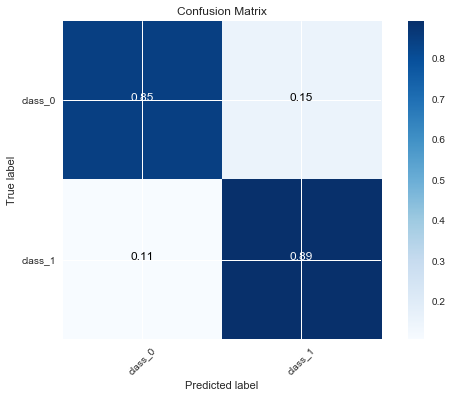

In [320]:
data_scaler = data_scalers["Standard Scaler"]
data_reducer = data_reducers["Correlations Removal"]
clf = neighbors.KNeighborsClassifier(n_neighbors = 27, \
                                     weights = "distance", \
                                     metric = "manhattan", \
                                     algorithm = "auto")
d_auc["KNN"] = Kfold_AUC(x, y, data_scaler, data_reducer, clf, plot = True)[0]

## Adaptive Boosting

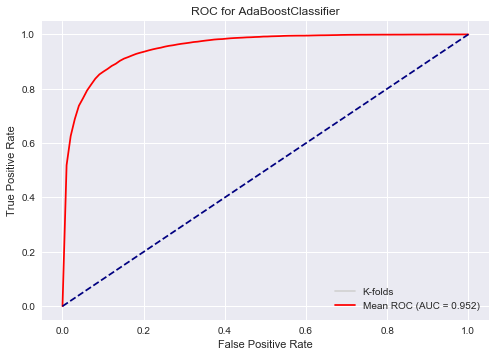

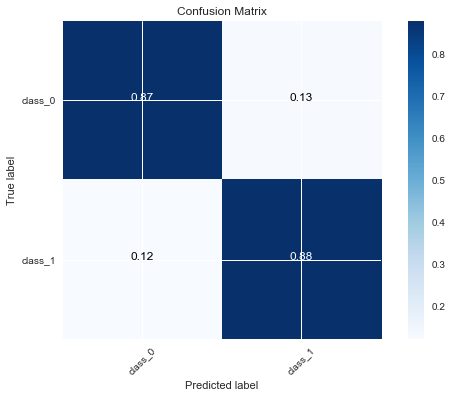

In [28]:
data_scaler = data_scalers["Standard Scaler"]
data_reducer = data_reducers["Correlations Removal"]
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 7), \
                                          n_estimators = 600, \
                                          algorithm = "SAMME")
d_auc["Adaptive Boosting"] = Kfold_AUC(x, y, data_scaler, data_reducer, clf, plot = True)[0]

## Neural Network

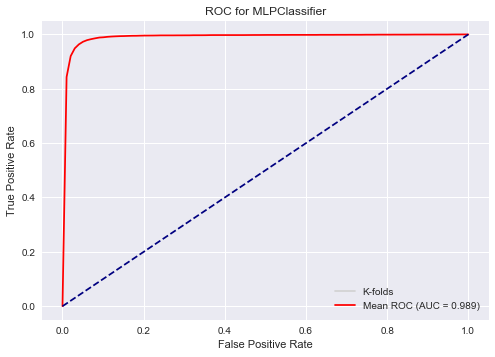

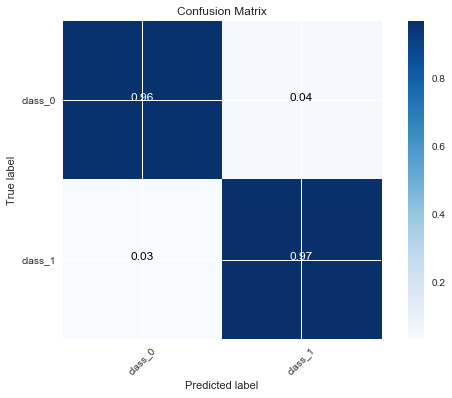

In [321]:
data_scaler = data_scalers["Standard Scaler"]
data_reducer = data_reducers["Correlations Removal"]
clf = MLPClassifier(activation = "relu", \
                    hidden_layer_sizes = (100, 150), \
                    alpha = 0.1, \
                    batch_size = 100, \
                    solver = "sgd", \
                    learning_rate = "adaptive", \
                    learning_rate_init = 0.1, \
                    power_t = 0.5, \
                    early_stopping = False, \
                    tol = 1e-4, \
                    warm_start = False, \
                    max_iter = 500)
d_auc["Neural Network"] = Kfold_AUC(x, y, data_scaler, data_reducer, clf, plot = True)[0]

# Results Summary

In [34]:
best_auc_models = []
for model_name in d_auc:
    model = OrderedDict()
    model["Model"] = model_name
    model["AUC (test)"] = d_auc[model_name]
    best_auc_models.append(model)
models_df = pd.DataFrame(best_auc_models)
display(HTML(models_df.to_html()))

,Model,AUC (test)
0,KNN,0.943498
1,GaussianNB,0.711944
2,Adaptive Boosting,0.951798
3,Neural Network,0.988813


### Neural Network got the best auc out of all models. Other measures to take into consideration:

## Accuracy

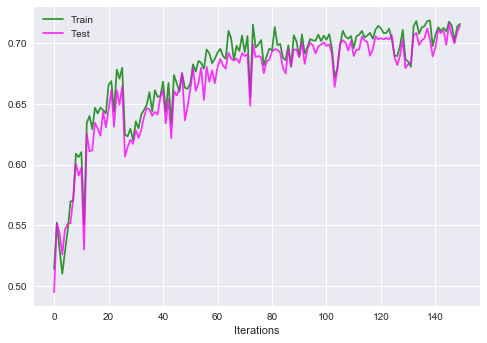

test accuracy: 0.713866666667
train accuracy: 0.715466666667


In [322]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = MLPClassifier(activation = "relu", \
                    hidden_layer_sizes = (100, 150), \
                    warm_start = True, \
                    max_iter = 1)
score_train, score_test = [], []
for i in range(150):
    clf.fit(x_train, y_train)
    score_test.append(clf.score(x_test, y_test))
    score_train.append(clf.score(x_train, y_train))
plt.plot(score_train, color='green', alpha=0.8, label='Train')
plt.plot(score_test, color='magenta', alpha=0.8, label='Test')
plt.xlabel('Iterations')
plt.legend(loc='upper left')
plt.show()
print "test accuracy:", clf.score(x_test, y_test)
print "train accuracy:", clf.score(x_train, y_train)

## Convergence

1.20064318413
0.738377874756
0.757701414238
0.749061863138
0.761524646751
0.751372458188
0.760833691181
0.763677324108
0.757217231153
0.745684317014
DONE!


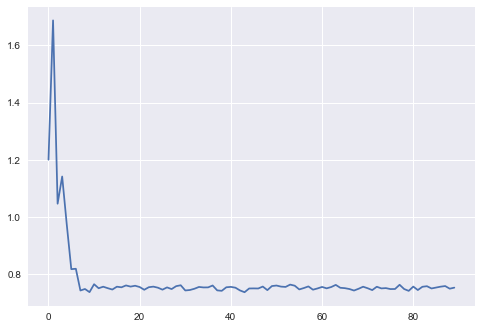

In [323]:
clf = MLPClassifier(activation = "relu", \
                    hidden_layer_sizes = (100, 150), \
                    learning_rate_init = 0.1, \
                    learning_rate = "adaptive", \
                    warm_start = True, \
                    batch_size = 100, \
                    max_iter = 1)
loss_history = []
last_loss = 0
for i in range(90):
    clf.fit(x, y)
    curr_loss = clf.loss_
    loss_history.append(curr_loss)
    if i%9 == 0:
        print curr_loss
    if abs(curr_loss - last_loss) < 0.0001:
        break
    last_loss = curr_loss
print "DONE!"
plt.plot(loss_history)
plt.show()

# Exporting to CSV

In [324]:
clf = MLPClassifier(activation = "relu",
                    hidden_layer_sizes = (100,150), \
                    alpha = 0.1, \
                    batch_size = 100, \
                    solver = "sgd", \
                    learning_rate = "adaptive", \
                    learning_rate_init = 0.1, \
                    power_t = 0.5, \
                    early_stopping = False, \
                    tol = 1e-4, \
                    warm_start = False, \
                    max_iter = 500)

# ----------------------------- Pre Processing --------------------------------  
# STAGE 1 - OUTLIERES REMOVAL
clean_df = outliers_removal(df)
x_train, y_train = clean_df.values[:,:-1], clean_df.values[:,-1]
x_test = df_test.values[:,:]

# STAGE 2 - SCALING
data_scaler.fit(x_train)
x_train = data_scaler.transform(x_train)
x_test = data_scaler.transform(x_test)

# STAGE 3 - DIMENSIONAL REDUCTION
# STAGE 3.1 - CORRELATIONS REMOVAL
correlations = correlations_detector(x_train)
x_train = correlations_removal(x_train, correlations).values[:,:]
x_test = correlations_removal(x_test, correlations).values[:,:]

# ---------------------------- Classifier Model --------------------------------        
# STAGE 4 - FITTING THE CLASSIFIER MODEL
clf.fit(x_train, y_train)

# STAGE 5 - PREDICTING
# predicting the test probabilities to "1" (=Positive) according to the our trained classifier model
probabilities = clf.predict_proba(x_test)
pd.DataFrame(probabilities).iloc[:,1].to_csv('submission_8.csv',header=["label"])